# Modeling Prediabetes & Diabetes Predictions from Health Survey Data

Table of Contents

* [1. Preprocessing](#Preprocessing)
    * [SelectKBest](#SKB)
    * [Resampling](#Undersampling)
    * [SMOTE](#SMOTE)
    * [Undersampling & SMOTE combined](#Combined)
    

* [2. Modeling](#Modeling)
    *  [Random Forest Classifier](#RFC)
        * [RFC: Undersampled data](#RFC:_Undersampled_data)
        * [RFC: SMOTE data](#RFC:_SMOTE)
        * [RFC: Undersampling & SMOTE combined](#RFC:_Combined)
    * [RFC Tuning](#Tuning)
        * [RFC Tuning: Undersampled](#RFC_Tuning_Undersampled)
        * [RFC Tuning: SelectKBest undersampled](#RFC_Tuning_SKB_Undersampled)
        * [RFC Tuning: Undersampled & SMOTE](#RFC_Tuning_Under_Over)
    * [Random Forest - OneVsRestClassifier (Tuning)](#RFC_OVRC)
    * [Histogram-Based Gradient Boosting (Tuning)](#HGBC)
    * [Histogram-Based Gradient Boosting - OneVRestClassifier (Tuning)](#HGBC_OVRC)
    
    
* [3. Model Summaries](#Summaries)

This notebook documents multiple modeling attemps using different model types and resampling methods.

## Imports

In [1]:
import os
import sys
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools


from collections import Counter

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import SelectKBest
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import metrics as m

module_names = ['precision_recall_curve',
                'f1_score',
                'auc',
                'accuracy_score',
                'classification_report',
                'confusion_matrix',
                'roc_curve',
                'roc_auc_score',
                'recall_score',
                'make_scorer',
                'ConfusionMatrixDisplay',
                'RocCurveDisplay']

import_metric_modules = map(__import__, module_names)

import_metric_modules

np.random.seed(137)

**Importing utility functions from separate files**

In [2]:
PROJ_ROOT = os.path.join(os.pardir, os.pardir)
data_path = os.path.join(PROJ_ROOT,
                        'data',
                        'raw',
                        'diabetes_012_health_indicators_BRFSS2015.csv')
src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)

import models.preprocess
import models.utility_funcs
from models.utility_funcs import plot_confusion_matrix
from models.utility_funcs import start_timer
from models.utility_funcs import end_timer
from models.utility_funcs import beep_when_done

**Preprocessing function loads data from csv, splits into training & testing sets, then scales non-binary values.**

In [3]:
X_train, X_test, y_train, y_test = models.preprocess.load_split_scale()
column_descriptions = models.preprocess.column_descriptions

**Plotting functions defined for convenience**

In [4]:
# Plotting functions
def plot_roc_ovr(y_test, y_proba, class_id):
    
    label_binarizer = LabelBinarizer().fit(y_train)
    y_test_onehot = label_binarizer.transform(y_test)
    
    class_key = {
        0:'No diabetes',
        1:'Prediabetes',
        2:'Diabetes'
    }
    
    class_name = class_key[class_id]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    m.RocCurveDisplay.from_predictions(
        y_test_onehot[:,class_id], 
        y_proba[:,class_id],
        name=f"{class_name} vs the rest",
        ax=ax
    )


    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves: {class_name}")
    plt.legend()
    plt.show()
    
def plot_all_roc_ovr(y_test, y_proba):
    
    label_binarizer = LabelBinarizer().fit(y_train)
    y_test_onehot = label_binarizer.transform(y_test)
    
    fig, ax = plt.subplots(figsize=(6, 6))

    class_key = {
        0:'No diabetes',
        1:'Prediabetes',
        2:'Diabetes'
    }

    colors = itertools.cycle(["red", "green", "blue"])
    for class_id, color in zip(range(3), colors):
        m.RocCurveDisplay.from_predictions(
            y_test_onehot[:, class_id],
            y_proba[:, class_id],
            name=f"ROC curve for {class_key[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC OvR multiclass")
    plt.legend()
    plt.show()

In [5]:
def plot_all_roc_ovr_test_train(y_test, y_proba, y_tr, y_tr_proba):
    
    label_binarizer = LabelBinarizer().fit(y_tr)
    y_test_onehot = label_binarizer.transform(y_test)
    y_tr_onehot = label_binarizer.transform(y_tr)
    #y_tr_onehot = label_binarizer.transform(y_train)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    class_key = {
        0:'No diabetes',
        1:'Prediabetes',
        2:'Diabetes'
    }

    colors = itertools.cycle(["red", "green", "blue"])
    for class_id, color in zip(range(3), colors):
        m.RocCurveDisplay.from_predictions(
            y_test_onehot[:, class_id],
            y_proba[:, class_id],
            name=f"ROC curve for {class_key[class_id]}",
            color=color,
            ax=ax[0],
        )

    ax[0].plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    ax[0].axis("square")
    ax[0].set_title("ROC OvR multiclass - Test Data")

    for class_id, color in zip(range(3), colors):
        m.RocCurveDisplay.from_predictions(
            y_tr_onehot[:, class_id],
            y_tr_proba[:, class_id],
            name=f"ROC curve for {class_key[class_id]}",
            color=color,
            ax=ax[1],
        )

    ax[1].plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    ax[1].axis("square")
    ax[1].set_title("ROC OvR multiclass - Train Data")

**Dataframes *model_summaries* and *model_metrics* used to track different models & parameters.**

In [6]:
model_summaries = pd.DataFrame(columns = ['Name', 'Train_data', 'params', 'param_grid', 'cv_params', 'best_params'])

In [7]:
def update_model_summaries(name, params, train_data, best_params=None, param_grid=None):
    """
    Converts param dict to a string.  Use ast.literal_eval() to convert params str to dict.
    """
    global model_summaries
    
    new_row = pd.Series({
        'Name': name,
        'Train_data': train_data,
        'params': str(params), 
        'param_grid': str(param_grid), 
#         'cv_params': str(cv_params),
        'best_params': str(param_grid),
    })
    
    model_summaries = pd.concat([new_row.to_frame().T, model_summaries], ignore_index = True)

    model_summaries.drop_duplicates(inplace=True)

In [8]:
model_metrics = pd.DataFrame(columns = ['Name', 'params', 'param_grid', 'best_params'])

In [9]:
def update_model_metrics(name, params, metrics_dict, param_grid=None, cv_params=None, best_params=None):
    """
    Update model_metrics df. Metrics_dict takes metrics as a dict to allow for new metrics without changing this function. Check that metric names match when updating df.
    Converts param dict to a string.  Use ast.literal_eval() to convert params str to dict.
    """
    global model_metrics
    
    new_row_dict = {**{'Name':name, 'params':str(params), 'param_grid':str(param_grid), 'best_params':str(best_params)}, **metrics_dict}
    new_row = pd.Series(new_row_dict)
    
    model_metrics = pd.concat([model_metrics, new_row.to_frame().T], ignore_index = True)
    model_metrics.drop_duplicates(subset=['Name', 'params'], inplace=True)

# Pre-Processing <a id='Preprocessing'></a>

## Select K Best  <a id='SKB'></a>

In [10]:
skb = SelectKBest(k=10)
X_skb_train = skb.fit_transform(X_train, y_train)
X_skb_test = skb.transform(X_test)

## Resampling 

### Undersampling <a id='Undersampling'></a>

In [11]:
rus = RandomUnderSampler(sampling_strategy = 'not minority', random_state=137)

X_under, y_under = rus.fit_resample(X_train, y_train)

In [12]:
print("Before Minority UnderSampling, counts of label '2': {}".format(sum(y_train == 2)))
print("Before Minority UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Minority UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
print("After Minority UnderSampling, counts of label '2': {}".format(sum(y_under == 2)))
print("After Minority UnderSampling, counts of label '1': {}".format(sum(y_under == 1)))
print("After Minority UnderSampling, counts of label '0': {}".format(sum(y_under == 0)))

Before Minority UnderSampling, counts of label '2': 21229
Before Minority UnderSampling, counts of label '1': 2785
Before Minority UnderSampling, counts of label '0': 128194 

After Minority UnderSampling, counts of label '2': 2785
After Minority UnderSampling, counts of label '1': 2785
After Minority UnderSampling, counts of label '0': 2785


In [13]:
# Resamble after selecting K best

X_skb_under, y_skb_under = rus.fit_resample(X_skb_train, y_train)

In [14]:
rus_majority = RandomUnderSampler(sampling_strategy = 'majority', random_state=137)

X_res_majority, y_res_majority = rus_majority.fit_resample(X_train, y_train)

print("Before Majority UnderSampling, counts of label '2': {}".format(sum(y_train == 2)))
print("Before Majority UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Majority UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
print("After Majority UnderSampling, counts of label '2': {}".format(sum(y_res_majority == 2)))
print("After Majority UnderSampling, counts of label '1': {}".format(sum(y_res_majority == 1)))
print("After Majority UnderSampling, counts of label '0': {}".format(sum(y_res_majority == 0)))

Before Majority UnderSampling, counts of label '2': 21229
Before Majority UnderSampling, counts of label '1': 2785
Before Majority UnderSampling, counts of label '0': 128194 

After Majority UnderSampling, counts of label '2': 21229
After Majority UnderSampling, counts of label '1': 2785
After Majority UnderSampling, counts of label '0': 2785


### SMOTE  <a id='SMOTE'></a>

In [15]:
smote = SMOTE(random_state=137)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("Before OverSampling, counts of label '2': {}".format(sum(y_train == 2)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
print("After OverSampling, counts of label '2': {}".format(sum(y_smote == 2)))
print("After OverSampling, counts of label '1': {}".format(sum(y_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote == 0)))

Before OverSampling, counts of label '2': 21229
Before OverSampling, counts of label '1': 2785
Before OverSampling, counts of label '0': 128194 

After OverSampling, counts of label '2': 128194
After OverSampling, counts of label '1': 128194
After OverSampling, counts of label '0': 128194


### Undersampling then SMOTE  <a id='Combined'></a>

In [16]:
total_class_0 = sum(y_train == 0)
total_class_1 = sum(y_train == 1)
total_class_2 = sum(y_train == 2)

rus2 = RandomUnderSampler(sampling_strategy = {0:total_class_2, 1:total_class_1, 2:total_class_2},
                          random_state=137)

X_res2, y_res2 = rus2.fit_resample(X_train, y_train)

smote2 = SMOTE(sampling_strategy='minority', random_state = 137)

X_under_over, y_under_over = smote2.fit_resample(X_res2, y_res2)

In [17]:
print("Before Resampling, counts of label '2': {}".format(sum(y_train == 2)))
print("Before Resampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Resampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
print("After Resampling, counts of label '2': {}".format(sum(y_under_over == 2)))
print("After Resampling, counts of label '1': {}".format(sum(y_under_over == 1)))
print("After Resampling, counts of label '0': {}".format(sum(y_under_over == 0)))

Before Resampling, counts of label '2': 21229
Before Resampling, counts of label '1': 2785
Before Resampling, counts of label '0': 128194 

After Resampling, counts of label '2': 21229
After Resampling, counts of label '1': 21229
After Resampling, counts of label '0': 21229


# Modeling <a id='Modeling'></a>

## Random Forest Classifier <a id='RFC'></a>

**Initial models**

### RFC: Undersampled data  <a id='RFC:_Undersampled_data'></a>

Start time:  15:53:17
End time:  15:53:22
Runtime:  0:00:04.428947 



,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"


Confusion matrix, without normalization
[[53063 17538 14908]
 [  478   547   821]
 [ 2080  3650  8387]]


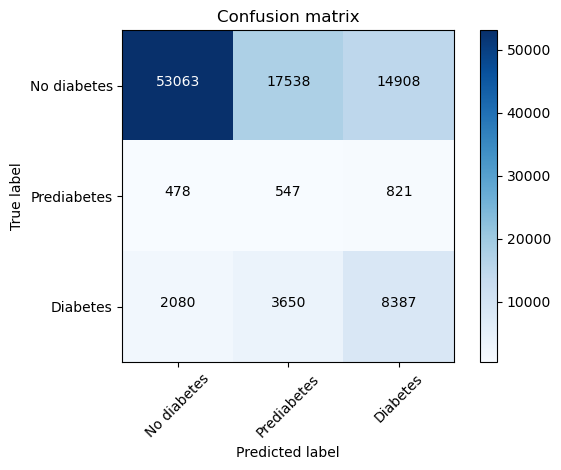

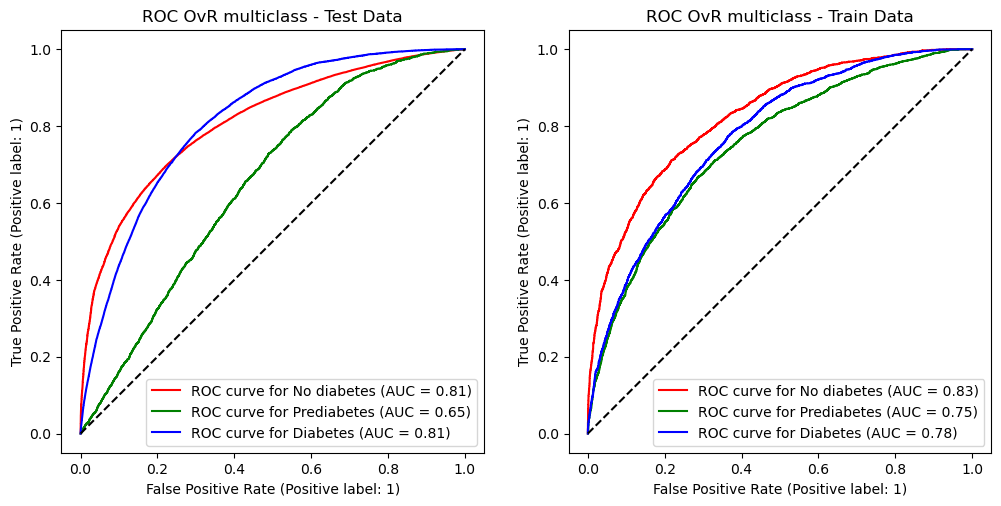

In [18]:
start_timer()

params = {
    'n_estimators':500,
    'criterion':'entropy',
    'max_depth':None,
    'max_features':20,
    'min_samples_split':100,
    'class_weight':'balanced',
    'n_jobs':-1,
    'random_state':137
}

rfc_under = RandomForestClassifier(**params)

rfc_under.fit(X_under, y_under)

y_pred = rfc_under.predict(X_test)
y_proba = rfc_under.predict_proba(X_test)

update_model_summaries('rfc_under', params, 'X_under, y_under')

y_tr_pred = rfc_under.predict(X_under)
y_tr_proba = rfc_under.predict_proba(X_under)

f1_test = m.f1_score(y_test, y_pred, average=None)
prec_scores_test = m.precision_score(y_test, y_pred, average=None)
rec_scores_test = m.recall_score(y_test, y_pred, average=None)

f1_train = m.f1_score(y_under, y_tr_pred, average=None)
prec_scores_train = m.precision_score(y_under, y_tr_pred, average=None)
rec_scores_train = m.recall_score(y_under, y_tr_pred, average=None)

update_model_metrics('rfc_under', params, {
    'f1_test':np.round(f1_test,2),
    'f1_train':np.round(f1_train,2),
    'precision_test':np.round(prec_scores_test,2),
    'precision_train':np.round(prec_scores_train,2),
    'recall_test':np.round(rec_scores_test,2),
    'recall_train':np.round(rec_scores_train,2),
})

end_timer()

display(model_metrics)

cm = m.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['No diabetes','Prediabetes','Diabetes'])

plot_all_roc_ovr_test_train(y_test, y_proba, y_under, y_tr_proba)

beep_when_done()

In [19]:
print('Accuracy: ', m.accuracy_score(y_test, rfc_under.predict(X_test)))
print('Metrics summary:')
display(model_metrics.loc[model_metrics['Name']=='rfc_under', 'f1_test':'recall_train'])

Accuracy:  0.6109764269946389
Metrics summary:


,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"


**Note each metric has three scores, one for each class of the target variable.  The target class corresponds to the center value.**

**Comments**

As an initial model this is acceptable. Interstingly it overfits only on the target class.

#### This second RFC model uses imbalanced class weights.

Start time:  15:53:24
End time:  15:53:29
Runtime:  0:00:04.482409 



,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"
1,rfc_under_2,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"


Confusion matrix, without normalization
[[47447 22285 15777]
 [  375   641   830]
 [ 1463  4118  8536]]


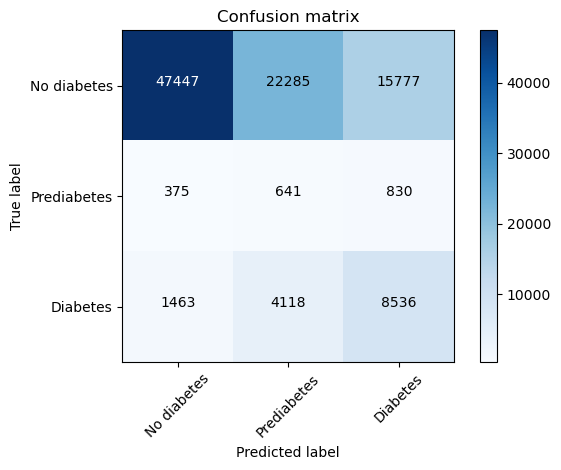

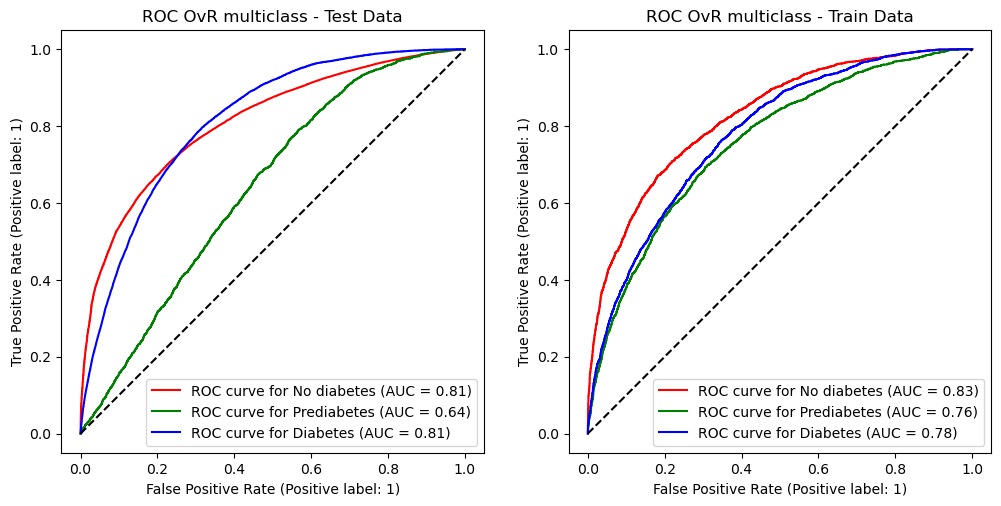

In [20]:
start_timer()

params = {
    'n_estimators':500,
    'criterion':'entropy',
    'max_depth':None,
    'max_features':20,
    'min_samples_split':100,
    'class_weight':{0:1,1:1.2,2:1.2},
    'n_jobs':-1,
    'random_state':137
}

rfc_under_2 = RandomForestClassifier(**params)

rfc_under_2.fit(X_under, y_under)

y_pred = rfc_under_2.predict(X_test)
y_proba = rfc_under_2.predict_proba(X_test)

update_model_summaries('rfc_under_2', params, 'X_under, y_under')

y_tr_pred = rfc_under_2.predict(X_under)
y_tr_proba = rfc_under_2.predict_proba(X_under)

f1_test = m.f1_score(y_test, y_pred, average=None)
prec_scores_test = m.precision_score(y_test, y_pred, average=None)
rec_scores_test = m.recall_score(y_test, y_pred, average=None)

f1_train = m.f1_score(y_under, y_tr_pred, average=None)
prec_scores_train = m.precision_score(y_under, y_tr_pred, average=None)
rec_scores_train = m.recall_score(y_under, y_tr_pred, average=None)

update_model_metrics('rfc_under_2', params, {
    'f1_test':np.round(f1_test,2),
    'f1_train':np.round(f1_train,2),
    'precision_test':np.round(prec_scores_test,2),
    'precision_train':np.round(prec_scores_train,2),
    'recall_test':np.round(rec_scores_test,2),
    'recall_train':np.round(rec_scores_train,2),
})

end_timer()

display(model_metrics)

cm = m.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['No diabetes','Prediabetes','Diabetes'])

plot_all_roc_ovr_test_train(y_test, y_proba, y_under, y_tr_proba)

beep_when_done()

In [21]:
print('Accuracy: ', m.accuracy_score(y_test, rfc_under_2.predict(X_test)))
print('Metrics summary:')
display(model_metrics.loc[model_metrics['Name']=='rfc_under_2', 'f1_test':'recall_train'])

Accuracy:  0.5580258593503626
Metrics summary:


,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
1,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"


**Comments**

Adjusting the weights of the target classes in training improves recall on the test set but has an unacceptably high cost in accuracy.  Balanced weighting yields an accuracy of ~61% while unbalanced weighting yields an accuracy of ~43%.

## RFC: SMOTE data <a id='RFC:_SMOTE'></a>

**Using SMOTE resampling leads to excessively long training times.**

In [22]:
%%script false

# Has excessively long training time

start_timer()

params = {
    'n_estimators':500,
    'criterion':'entropy',
    'max_depth':None,
    'max_features':20,
    'min_samples_split':100,
    'class_weight':'balanced',
    'n_jobs':-1,
    'random_state':137
}

rfc_smote = RandomForestClassifier(**params)

rfc_smote.fit(X_smote, y_smote)

y_pred = rfc_smote.predict(X_test)
y_proba = rfc_smote.predict_proba(X_test)

update_model_summaries('rfc_smote', params, 'X_smote, y_smote')

y_tr_pred = rfc_smote.predict(X_smote)
y_tr_proba = rfc_smote.predict_proba(X_smote)

f1_test = m.f1_score(y_test, y_pred, average=None)
prec_scores_test = m.precision_score(y_test, y_pred, average=None)
rec_scores_test = m.recall_score(y_test, y_pred, average=None)

f1_train = m.f1_score(y_smote, y_tr_pred, average=None)
prec_scores_train = m.precision_score(y_smote, y_tr_pred, average=None)
rec_scores_train = m.recall_score(y_smote, y_tr_pred, average=None)

update_model_metrics('rfc_smote', params, {
    'f1_test':np.round(f1_test,2),
    'f1_train':np.round(f1_train,2),
    'precision_test':np.round(prec_scores_test,2),
    'precision_train':np.round(prec_scores_train,2),
    'recall_test':np.round(rec_scores_test,2),
    'recall_train':np.round(rec_scores_train,2),
})

end_timer()
beep_when_done()

display(model_metrics)

cm = m.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['No diabetes','Prediabetes','Diabetes'])

plot_all_roc_ovr_test_train(y_test, y_proba, y_smote, y_tr_proba)

Couldn't find program: 'false'


**Comments**

Using SMOTE on training data leads to excessively long training times.

### RFC:  Undersampled then oversampled using SMOTE.  <a id='RFC:_Combined'></a>

Start time:  15:53:31
End time:  15:55:06
Runtime:  0:01:35.594404 



,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"
1,rfc_under_2,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"
2,rfc_under_over,"{'n_estimators': 1000, 'criterion': 'entropy',...",None,None,"[0.81, 0.01, 0.44]","[0.72, 0.89, 0.73]","[0.94, 0.03, 0.3]","[0.71, 0.99, 0.67]","[0.71, 0.0, 0.79]","[0.72, 0.81, 0.79]"


Confusion matrix, without normalization
[[60639   281 24589]
 [  649     9  1188]
 [ 2963    38 11116]]


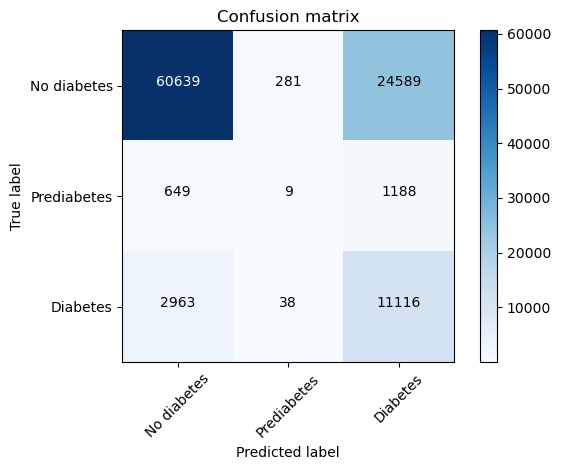

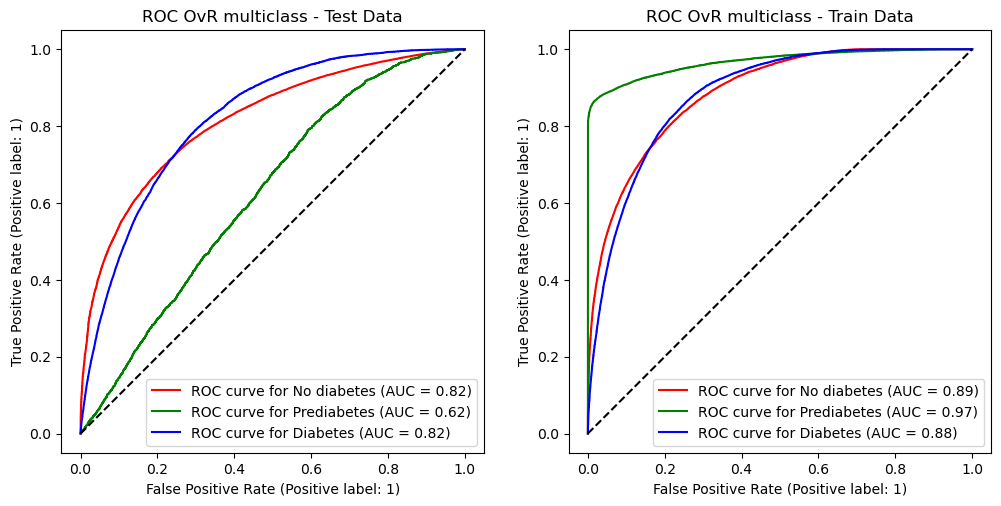

In [23]:
start_timer()

params = {
    'n_estimators':1000,
    'criterion':'entropy',
    'max_depth':None,
    'max_features':20,
    'min_samples_split':200,
    'class_weight':'balanced',
    'n_jobs':4,
    'random_state':137
}

rfc_under_over = RandomForestClassifier(**params)

rfc_under_over.fit(X_under_over, y_under_over)

y_pred = rfc_under_over.predict(X_test)
y_proba = rfc_under_over.predict_proba(X_test)

update_model_summaries('rfc_under_over', params, 'X_under_over, y_under_over')

y_tr_pred = rfc_under_over.predict(X_under_over)
y_tr_proba = rfc_under_over.predict_proba(X_under_over)

f1_test = m.f1_score(y_test, y_pred, average=None)
prec_scores_test = m.precision_score(y_test, y_pred, average=None)
rec_scores_test = m.recall_score(y_test, y_pred, average=None)

f1_train = m.f1_score(y_under_over, y_tr_pred, average=None)
prec_scores_train = m.precision_score(y_under_over, y_tr_pred, average=None)
rec_scores_train = m.recall_score(y_under_over, y_tr_pred, average=None)

update_model_metrics('rfc_under_over', params, {
    'f1_test':np.round(f1_test,2),
    'f1_train':np.round(f1_train,2),
    'precision_test':np.round(prec_scores_test,2),
    'precision_train':np.round(prec_scores_train,2),
    'recall_test':np.round(rec_scores_test,2),
    'recall_train':np.round(rec_scores_train,2),
})

end_timer()
beep_when_done()

display(model_metrics)

cm = m.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['No diabetes','Prediabetes','Diabetes'])

plot_all_roc_ovr_test_train(y_test, y_proba, y_under_over, y_tr_proba)

**Comments**

Unacceptable overfitting.  Does not provide sufficient improvement over using only undersampling of data.

## Tuning  <a id='Tuning'></a>

## Function: Rand Search CV

In [24]:
def rand_search_cv(model, model_name, X_train, X_name, y_train, y_name, X_test=X_test):

    global param_grid, cv_params
    
    start_timer()

    model_search = model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    end_timer()

    update_model_summaries(model_name, params, X_name + ", " + y_name, param_grid = param_grid, best_params = model.best_params_)

    y_tr_pred = model.predict(X_train)
    y_tr_proba = model.predict_proba(X_train)

    f1_test = m.f1_score(y_test, y_pred, average=None)
    prec_scores_test = m.precision_score(y_test, y_pred, average=None)
    rec_scores_test = m.recall_score(y_test, y_pred, average=None)

    f1_train = m.f1_score(y_train, y_tr_pred, average=None)
    prec_scores_train = m.precision_score(y_train, y_tr_pred, average=None)
    rec_scores_train = m.recall_score(y_train, y_tr_pred, average=None)

    update_model_metrics(model_name, params, 
                         {
                             'f1_test':np.round(f1_test,2),
                             'f1_train':np.round(f1_train,2),
                             'precision_test':np.round(prec_scores_test,2),
                             'precision_train':np.round(prec_scores_train,2),
                             'recall_test':np.round(rec_scores_test,2),
                             'recall_train':np.round(rec_scores_train,2)
                         },
                         param_grid = param_grid, best_params = model.best_params_
                        )

    display(model_metrics)

    cm = m.confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['No diabetes','Prediabetes','Diabetes'])

    plot_all_roc_ovr_test_train(y_test, y_proba, y_train, y_tr_proba)
    
    beep_when_done()

### RFC Tuning - Undersampled data  <a id='RFC_Tuning_Undersampled'></a>

Start time:  15:55:08
End time:  15:57:36
Runtime:  0:02:28.030030 



,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"
1,rfc_under_2,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"
2,rfc_under_over,"{'n_estimators': 1000, 'criterion': 'entropy',...",None,None,"[0.81, 0.01, 0.44]","[0.72, 0.89, 0.73]","[0.94, 0.03, 0.3]","[0.71, 0.99, 0.67]","[0.71, 0.0, 0.79]","[0.72, 0.81, 0.79]"
3,rfc_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 30, 'max_features': 2, '...","[0.76, 0.05, 0.44]","[0.72, 0.65, 0.71]","[0.96, 0.03, 0.34]","[0.71, 0.75, 0.65]","[0.63, 0.29, 0.62]","[0.72, 0.58, 0.79]"


Confusion matrix, without normalization
[[53660 15770 16079]
 [  461   541   844]
 [ 1997  3335  8785]]


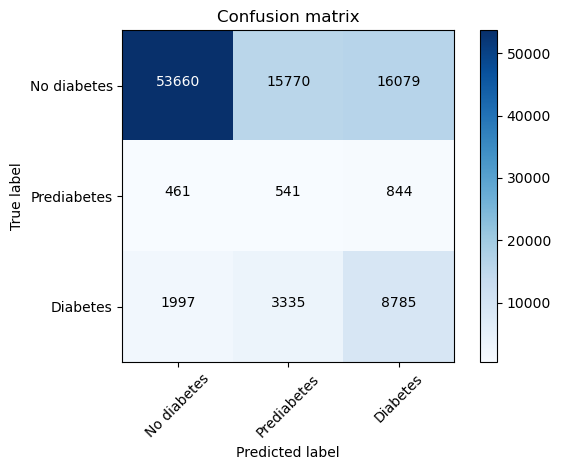

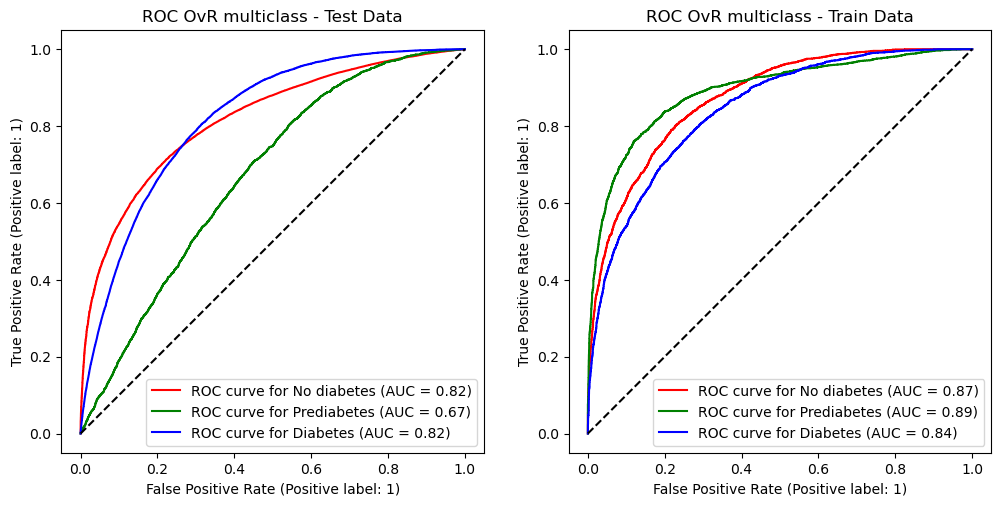

In [25]:
params = {
    'class_weight':'balanced',
    'n_estimators':1000,
    'criterion':'entropy',
    'n_jobs':4
}

param_grid = {
    'max_features':range(2,21),
    'max_depth':[5, 7, 10, 15, 20, 50, 100, 500, 1000],
    'min_samples_split':range(2,200),
}

cv_params = {
    'n_iter':20,
    'n_jobs':4
}


rfc_under_cv = RandomizedSearchCV(
    RandomForestClassifier(**params, random_state=137), 
    param_grid, 
    **cv_params, 
    random_state=137)

rand_search_cv(rfc_under_cv, 'rfc_under_cv', X_under, 'X_under', y_under, 'y_under')

In [26]:
pd.DataFrame(rfc_under_cv.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,3.837229,0.068359,0.492488,0.041541,30,2,50,"{'min_samples_split': 30, 'max_features': 2, '...",0.505087,0.509276,0.512268,0.516457,0.530221,0.514662,0.008623,1
11,4.169172,0.133993,0.364482,0.025200,109,8,20,"{'min_samples_split': 109, 'max_features': 8, ...",0.511670,0.507481,0.512867,0.511071,0.527828,0.514183,0.007055,2
16,5.620083,0.168239,0.443740,0.041608,52,12,50,"{'min_samples_split': 52, 'max_features': 12, ...",0.523639,0.503890,0.503890,0.510473,0.521843,0.512747,0.008526,3
2,4.915909,0.088609,0.427728,0.029068,63,10,500,"{'min_samples_split': 63, 'max_features': 10, ...",0.517056,0.507481,0.503291,0.511071,0.520646,0.511909,0.006283,4
12,3.449187,0.083982,0.341471,0.013001,90,5,7,"{'min_samples_split': 90, 'max_features': 5, '...",0.509276,0.496709,0.502693,0.509874,0.536804,0.511071,0.013736,5


In [27]:
pd.DataFrame(rfc_under_cv.cv_results_).sort_values('rank_test_score').tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,3.423470,0.045273,0.350489,0.018374,183,7,5,"{'min_samples_split': 183, 'max_features': 7, ...",0.499102,0.495512,0.500898,0.503291,0.529025,0.505566,0.012001,16
18,3.088487,0.112523,0.357492,0.015258,188,4,5,"{'min_samples_split': 188, 'max_features': 4, ...",0.487732,0.504488,0.502095,0.500299,0.528426,0.504608,0.013244,17
17,5.083095,0.198335,0.367581,0.040863,195,18,15,"{'min_samples_split': 195, 'max_features': 18,...",0.491921,0.500898,0.501496,0.502095,0.526631,0.504608,0.011625,18
13,5.407527,0.195446,0.379895,0.029939,168,19,10,"{'min_samples_split': 168, 'max_features': 19,...",0.496110,0.500898,0.503890,0.497905,0.523040,0.504369,0.009704,19
19,5.180731,0.375822,0.345189,0.076221,195,20,1000,"{'min_samples_split': 195, 'max_features': 20,...",0.487732,0.499701,0.503890,0.500299,0.526631,0.503651,0.012715,20


In [28]:
print('Accuracy: ', m.accuracy_score(y_test, rfc_under_cv.predict(X_test)))
print('Metrics summary:')
display(model_metrics.loc[model_metrics['Name']=='rfc_under_cv', ['Name', 'f1_test', 'f1_train',
       'precision_test', 'precision_train', 'recall_test', 'recall_train']])

Accuracy:  0.6207229580573952
Metrics summary:


,Name,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
3,rfc_under_cv,"[0.76, 0.05, 0.44]","[0.72, 0.65, 0.71]","[0.96, 0.03, 0.34]","[0.71, 0.75, 0.65]","[0.63, 0.29, 0.62]","[0.72, 0.58, 0.79]"


**Comments**

* Unacceptable overfitting.
* Trivial difference in test scores between worst and best performing parameters.

## RFC: SelectKBest then undersampled data  <a id='RFC_Tuning_SKB_Undersampled'></a>

Start time:  15:57:42
End time:  15:59:56
Runtime:  0:02:14.211971 



,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"
1,rfc_under_2,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"
2,rfc_under_over,"{'n_estimators': 1000, 'criterion': 'entropy',...",None,None,"[0.81, 0.01, 0.44]","[0.72, 0.89, 0.73]","[0.94, 0.03, 0.3]","[0.71, 0.99, 0.67]","[0.71, 0.0, 0.79]","[0.72, 0.81, 0.79]"
3,rfc_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 30, 'max_features': 2, '...","[0.76, 0.05, 0.44]","[0.72, 0.65, 0.71]","[0.96, 0.03, 0.34]","[0.71, 0.75, 0.65]","[0.63, 0.29, 0.62]","[0.72, 0.58, 0.79]"
4,rfc_skb_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 135, 'max_features': 4, ...","[0.76, 0.05, 0.44]","[0.64, 0.41, 0.58]","[0.95, 0.03, 0.35]","[0.63, 0.49, 0.53]","[0.63, 0.29, 0.61]","[0.66, 0.36, 0.64]"


Confusion matrix, without normalization
[[54003 16123 15383]
 [  476   541   829]
 [ 2083  3380  8654]]


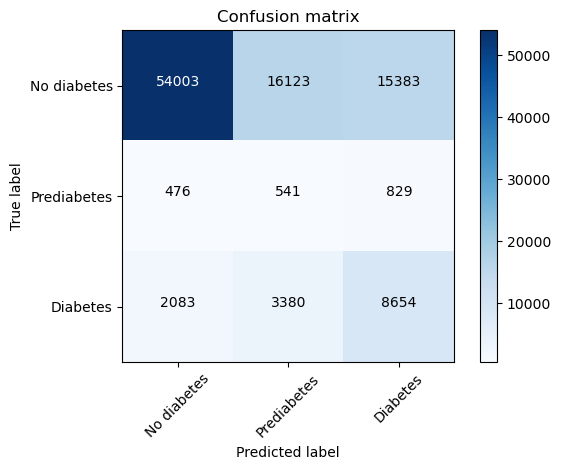

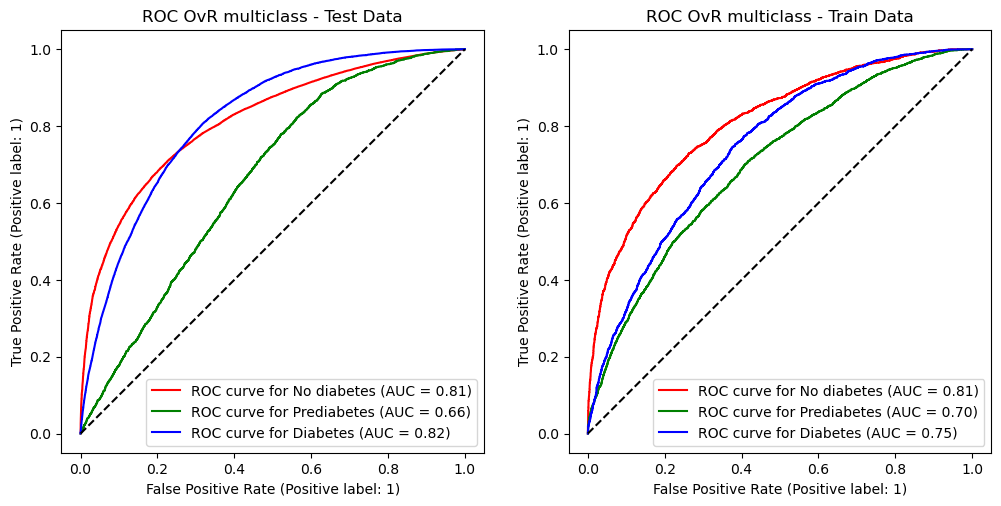

In [29]:
params = {
    'class_weight':'balanced',
    'n_estimators':1000,
    'criterion':'entropy',
    'n_jobs':4
}

param_grid = {
    'max_features':range(2,21),
    'max_depth':[5, 7, 10, 15, 20, 50, 100, 500, 1000],
    'min_samples_split':range(2,200),
}

cv_params = {
    'n_iter':20,
    'n_jobs':4
}


rfc_skb_under_cv = RandomizedSearchCV(
    RandomForestClassifier(**params, random_state=137), 
    param_grid, 
    **cv_params, 
    random_state=137)

rand_search_cv(rfc_skb_under_cv, 'rfc_skb_under_cv', X_skb_under, 'X_skb_under', y_skb_under, 'y_skb_under', X_test = X_skb_test)

In [30]:
pd.DataFrame(rfc_skb_under_cv.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,3.501489,0.083857,0.339181,0.014492,135,4,10,"{'min_samples_split': 135, 'max_features': 4, ...",0.503291,0.502693,0.508677,0.508677,0.519449,0.508558,0.006013,1
12,3.643532,0.072061,0.357702,0.026581,90,5,7,"{'min_samples_split': 90, 'max_features': 5, '...",0.500299,0.500898,0.507481,0.508677,0.524237,0.508318,0.008644,2
18,3.206488,0.121365,0.332453,0.008280,188,4,5,"{'min_samples_split': 188, 'max_features': 4, ...",0.495512,0.496110,0.497307,0.505087,0.527828,0.504369,0.012226,3
3,3.840993,0.156424,0.434662,0.012119,30,2,50,"{'min_samples_split': 30, 'max_features': 2, '...",0.502095,0.493716,0.503291,0.505087,0.516457,0.504129,0.007296,4
14,4.087260,0.094990,0.354633,0.031644,195,8,50,"{'min_samples_split': 195, 'max_features': 8, ...",0.491921,0.496709,0.500299,0.503291,0.527229,0.503890,0.012270,5


In [31]:
pd.DataFrame(rfc_skb_under_cv.cv_results_).sort_values('rank_test_score').tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,5.832759,0.140398,0.386277,0.057707,52,12,50,"{'min_samples_split': 52, 'max_features': 12, ...",0.502693,0.494913,0.499701,0.490126,0.518851,0.501257,0.009779,16
2,5.364115,0.069090,0.434573,0.036822,63,10,500,"{'min_samples_split': 63, 'max_features': 10, ...",0.501496,0.491323,0.503291,0.493118,0.515260,0.500898,0.008539,17
7,5.298781,0.039656,0.374871,0.026035,93,20,500,"{'min_samples_split': 93, 'max_features': 20, ...",0.499701,0.492519,0.501496,0.494913,0.514662,0.500658,0.007707,18
6,5.241261,0.119788,0.384601,0.030251,87,15,15,"{'min_samples_split': 87, 'max_features': 15, ...",0.502693,0.491323,0.499102,0.494315,0.515260,0.500539,0.008332,19
8,5.348604,0.045865,0.385544,0.043614,68,15,10,"{'min_samples_split': 68, 'max_features': 15, ...",0.503291,0.488330,0.502693,0.494315,0.514063,0.500539,0.008751,19


In [32]:
print('Accuracy: ', m.accuracy_score(y_test, rfc_skb_under_cv.predict(X_skb_test)))
print('Metrics summary:')
display(model_metrics.loc[model_metrics['Name']=='rfc_skb_under_cv', ['Name', 'f1_test', 'f1_train',
       'precision_test', 'precision_train', 'recall_test', 'recall_train']])

Accuracy:  0.6228122043519394
Metrics summary:


,Name,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
4,rfc_skb_under_cv,"[0.76, 0.05, 0.44]","[0.64, 0.41, 0.58]","[0.95, 0.03, 0.35]","[0.63, 0.49, 0.53]","[0.63, 0.29, 0.61]","[0.66, 0.36, 0.64]"


**Comments**

* SelectKBest does not offer significant improvement.
* Again trivial differences between scores of best & worst performing parameters

## RFC Tuning: Undersampled & SMOTE <a id='RFC_Tuning_Under_Over'></a>

Start time:  16:00:02
End time:  16:17:26
Runtime:  0:17:23.834953 



,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"
1,rfc_under_2,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"
2,rfc_under_over,"{'n_estimators': 1000, 'criterion': 'entropy',...",None,None,"[0.81, 0.01, 0.44]","[0.72, 0.89, 0.73]","[0.94, 0.03, 0.3]","[0.71, 0.99, 0.67]","[0.71, 0.0, 0.79]","[0.72, 0.81, 0.79]"
3,rfc_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 30, 'max_features': 2, '...","[0.76, 0.05, 0.44]","[0.72, 0.65, 0.71]","[0.96, 0.03, 0.34]","[0.71, 0.75, 0.65]","[0.63, 0.29, 0.62]","[0.72, 0.58, 0.79]"
4,rfc_skb_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 135, 'max_features': 4, ...","[0.76, 0.05, 0.44]","[0.64, 0.41, 0.58]","[0.95, 0.03, 0.35]","[0.63, 0.49, 0.53]","[0.63, 0.29, 0.61]","[0.66, 0.36, 0.64]"
5,rfc_under_over_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'max_features': 4, 'max_depth': 50}","[0.81, 0.01, 0.44]","[0.73, 0.92, 0.74]","[0.95, 0.02, 0.3]","[0.75, 0.99, 0.69]","[0.71, 0.01, 0.79]","[0.72, 0.86, 0.81]"


Confusion matrix, without normalization
[[60451   382 24676]
 [  635    11  1200]
 [ 2857    64 11196]]


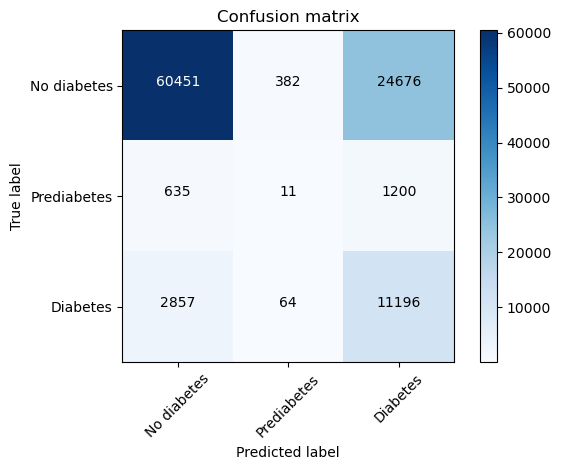

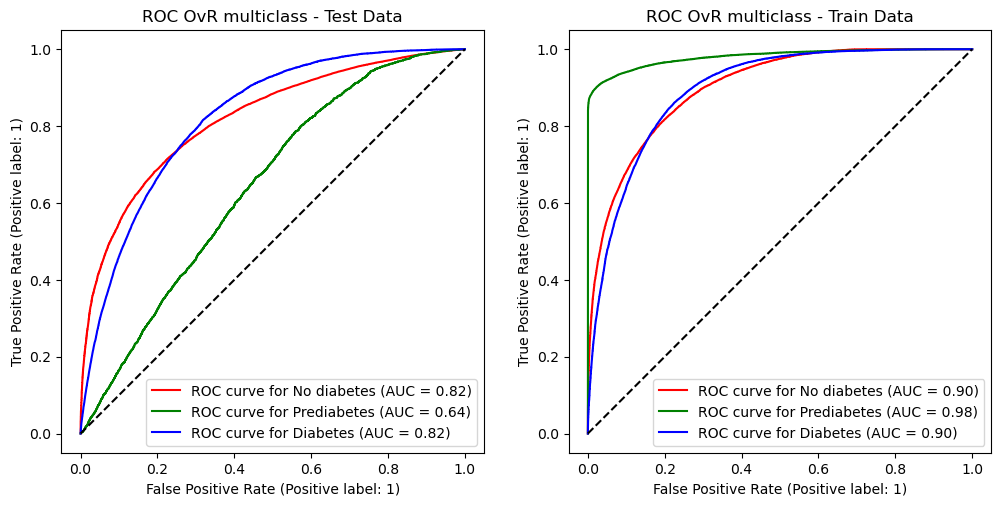

In [33]:
# Long training time


params = {
    'class_weight':'balanced',
    'n_estimators':1000,
    'min_samples_split':100,
    'criterion':'entropy',
    'n_jobs':4
}

param_grid = {
    'max_features':range(2,21),
    'max_depth':[5, 7, 10, 15, 20, 50, 100]
}

cv_params = {
    'n_iter':10,
    'n_jobs':4
}


rfc_under_over_cv = RandomizedSearchCV(
    RandomForestClassifier(**params, random_state=137), 
    param_grid, 
    **cv_params, 
    random_state=137)

rand_search_cv(rfc_under_over_cv, 'rfc_under_over_cv', X_under_over, 'X_under_over', y_under_over, 'y_under_over')

In [34]:
pd.DataFrame(rfc_under_over_cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,43.863329,1.851901,1.595807,0.169708,4,50,"{'max_features': 4, 'max_depth': 50}",0.608180,0.814178,0.816283,0.810316,0.823114,0.774414,0.083221,1
6,101.859182,5.957776,1.502982,0.087217,12,20,"{'max_features': 12, 'max_depth': 20}",0.603313,0.810410,0.812750,0.808589,0.818482,0.770709,0.083764,2
3,128.511111,3.526699,1.459025,0.075788,16,20,"{'max_features': 16, 'max_depth': 20}",0.600094,0.808055,0.809688,0.808432,0.816440,0.768542,0.084279,3
5,156.533145,7.251143,1.387892,0.180887,20,20,"{'max_features': 20, 'max_depth': 20}",0.597268,0.808526,0.808589,0.806155,0.814792,0.767066,0.084947,4
8,58.701800,6.366357,0.979943,0.108692,8,15,"{'max_features': 8, 'max_depth': 15}",0.599388,0.804993,0.806626,0.800031,0.812436,0.764695,0.082748,5
2,106.524574,5.265586,1.168620,0.048147,17,10,"{'max_features': 17, 'max_depth': 10}",0.574187,0.731983,0.739892,0.732512,0.747900,0.705295,0.065809,6
0,21.874785,0.778016,0.815847,0.082919,4,5,"{'max_features': 4, 'max_depth': 5}",0.567907,0.704428,0.708016,0.698516,0.714532,0.678680,0.055629,7
7,71.361442,4.117755,0.724217,0.084397,15,7,"{'max_features': 15, 'max_depth': 7}",0.552599,0.673104,0.688859,0.672058,0.694748,0.656273,0.052579,8
4,47.876790,1.789722,0.901915,0.038578,12,5,"{'max_features': 12, 'max_depth': 5}",0.541608,0.639033,0.658083,0.646699,0.661930,0.629470,0.044677,9
9,50.814983,10.126582,0.544025,0.171003,18,5,"{'max_features': 18, 'max_depth': 5}",0.531324,0.615089,0.626914,0.624323,0.642380,0.608006,0.039334,10


In [35]:
print('Accuracy: ', m.accuracy_score(y_test, rfc_under_over_cv.predict(X_test)))
print('Metrics summary:')
display(model_metrics.loc[model_metrics['Name']=='rfc_under_over_cv', ['Name', 'f1_test', 'f1_train',
       'precision_test', 'precision_train', 'recall_test', 'recall_train']])

Accuracy:  0.7061849574266793
Metrics summary:


,Name,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
5,rfc_under_over_cv,"[0.81, 0.01, 0.44]","[0.73, 0.92, 0.74]","[0.95, 0.02, 0.3]","[0.75, 0.99, 0.69]","[0.71, 0.01, 0.79]","[0.72, 0.86, 0.81]"


* Massively overfits

## Random Forest - OneVsRestClassifier <a id='RFC_OVRC'></a>

Start time:  16:17:38
End time:  16:24:04
Runtime:  0:06:26.474238 



,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"
1,rfc_under_2,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"
2,rfc_under_over,"{'n_estimators': 1000, 'criterion': 'entropy',...",None,None,"[0.81, 0.01, 0.44]","[0.72, 0.89, 0.73]","[0.94, 0.03, 0.3]","[0.71, 0.99, 0.67]","[0.71, 0.0, 0.79]","[0.72, 0.81, 0.79]"
3,rfc_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 30, 'max_features': 2, '...","[0.76, 0.05, 0.44]","[0.72, 0.65, 0.71]","[0.96, 0.03, 0.34]","[0.71, 0.75, 0.65]","[0.63, 0.29, 0.62]","[0.72, 0.58, 0.79]"
4,rfc_skb_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 135, 'max_features': 4, ...","[0.76, 0.05, 0.44]","[0.64, 0.41, 0.58]","[0.95, 0.03, 0.35]","[0.63, 0.49, 0.53]","[0.63, 0.29, 0.61]","[0.66, 0.36, 0.64]"
5,rfc_under_over_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'max_features': 4, 'max_depth': 50}","[0.81, 0.01, 0.44]","[0.73, 0.92, 0.74]","[0.95, 0.02, 0.3]","[0.75, 0.99, 0.69]","[0.71, 0.01, 0.79]","[0.72, 0.86, 0.81]"
6,rfc_under_ovrc_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'estimator__max_features': range(2, 21), 'est...","{'estimator__min_samples_split': 47, 'estimato...","[0.75, 0.05, 0.44]","[0.71, 0.62, 0.7]","[0.96, 0.03, 0.34]","[0.71, 0.7, 0.64]","[0.62, 0.31, 0.61]","[0.71, 0.56, 0.76]"


Confusion matrix, without normalization
[[52947 16917 15645]
 [  450   570   826]
 [ 1903  3545  8669]]


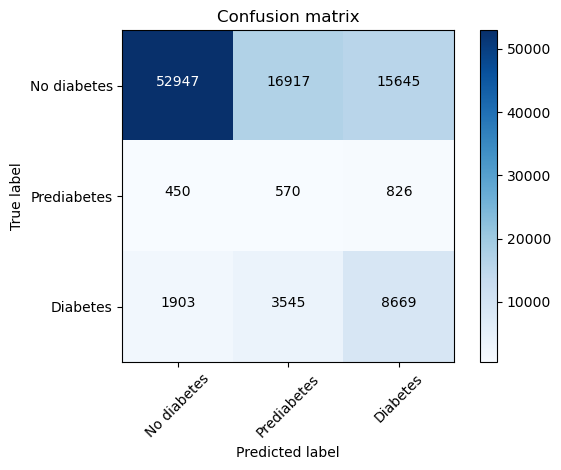

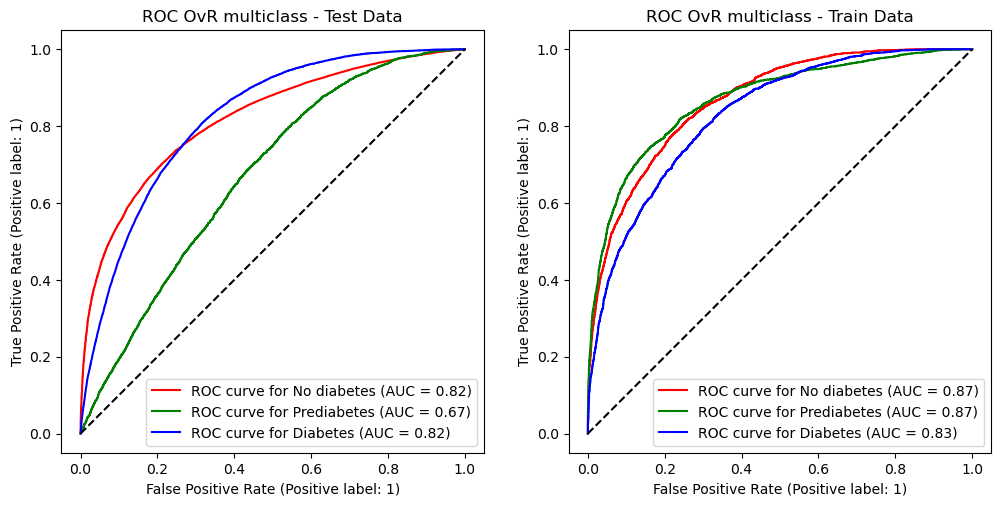

In [36]:
params = {
    'class_weight':'balanced',
    'n_estimators':1000,
    'criterion':'entropy',
    'n_jobs':4
}

param_grid = {
    'estimator__max_features':range(2,21),
    'estimator__max_depth':[5, 7, 10, 15, 20, 50, 100, 500, 1000],
    'estimator__min_samples_split':range(20,200),
}

cv_params = {
    'n_iter':20,
    'n_jobs':4
}


ovrc = OneVsRestClassifier(RandomForestClassifier(**params), n_jobs=-4)

rfc_under_ovrc_cv = RandomizedSearchCV(
    ovrc,
    param_grid,
    **cv_params,
    random_state=137
)


rand_search_cv(rfc_under_ovrc_cv, 'rfc_under_ovrc_cv', X_under, 'X_under', y_under, 'y_under')

**Comments**

* Significantly overfits for target class.  Minor overfitting for other classes.

In [37]:
pd.DataFrame(rfc_under_ovrc_cv.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__min_samples_split,param_estimator__max_features,param_estimator__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,10.462317,0.311590,0.976760,0.022260,47,4,15,"{'estimator__min_samples_split': 47, 'estimato...",0.514662,0.515859,0.510473,0.511670,0.536804,0.517893,0.009654,1
13,11.849524,0.083339,0.990199,0.022840,47,6,50,"{'estimator__min_samples_split': 47, 'estimato...",0.518253,0.512867,0.508079,0.515260,0.525434,0.515978,0.005782,2
2,13.646245,0.391053,1.642592,0.039177,29,5,100,"{'estimator__min_samples_split': 29, 'estimato...",0.515859,0.508677,0.502693,0.521245,0.523639,0.514423,0.007799,3
12,8.545928,0.065702,0.914347,0.013165,105,3,20,"{'estimator__min_samples_split': 105, 'estimat...",0.508677,0.514662,0.506882,0.509276,0.532615,0.514423,0.009459,3
5,9.774799,0.049681,0.927194,0.008673,99,5,1000,"{'estimator__min_samples_split': 99, 'estimato...",0.514063,0.506284,0.511071,0.505087,0.529623,0.513226,0.008816,5


In [38]:
pd.DataFrame(rfc_under_ovrc_cv.cv_results_).sort_values('rank_test_score').tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__min_samples_split,param_estimator__max_features,param_estimator__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,9.511652,0.092594,0.906666,0.032848,130,7,7,"{'estimator__min_samples_split': 130, 'estimat...",0.510473,0.502693,0.504488,0.507481,0.525434,0.510114,0.008105,16
16,10.052434,0.163539,0.930101,0.027189,47,10,5,"{'estimator__min_samples_split': 47, 'estimato...",0.507481,0.499701,0.503291,0.505087,0.531418,0.509396,0.011300,17
8,21.616736,0.338429,1.361628,0.032163,61,19,50,"{'estimator__min_samples_split': 61, 'estimato...",0.511670,0.503291,0.506284,0.507481,0.517056,0.509156,0.004779,18
1,18.073168,0.444595,1.409134,0.073922,26,11,50,"{'estimator__min_samples_split': 26, 'estimato...",0.506882,0.513465,0.500898,0.515260,0.508079,0.508917,0.005100,19
15,22.452209,0.424038,0.994376,0.036605,43,19,100,"{'estimator__min_samples_split': 43, 'estimato...",0.508677,0.505087,0.497307,0.508677,0.514063,0.506762,0.005529,20


**Comments**

* Trivial difference between test scores for best & worst performing parameters

## Histogram-Based Gradient Boosting (LightGBM) <a id='HGBC'></a>

Start time:  16:24:12
End time:  16:29:33
Runtime:  0:05:20.853658 



,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"
1,rfc_under_2,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"
2,rfc_under_over,"{'n_estimators': 1000, 'criterion': 'entropy',...",None,None,"[0.81, 0.01, 0.44]","[0.72, 0.89, 0.73]","[0.94, 0.03, 0.3]","[0.71, 0.99, 0.67]","[0.71, 0.0, 0.79]","[0.72, 0.81, 0.79]"
3,rfc_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 30, 'max_features': 2, '...","[0.76, 0.05, 0.44]","[0.72, 0.65, 0.71]","[0.96, 0.03, 0.34]","[0.71, 0.75, 0.65]","[0.63, 0.29, 0.62]","[0.72, 0.58, 0.79]"
4,rfc_skb_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 135, 'max_features': 4, ...","[0.76, 0.05, 0.44]","[0.64, 0.41, 0.58]","[0.95, 0.03, 0.35]","[0.63, 0.49, 0.53]","[0.63, 0.29, 0.61]","[0.66, 0.36, 0.64]"
5,rfc_under_over_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'max_features': 4, 'max_depth': 50}","[0.81, 0.01, 0.44]","[0.73, 0.92, 0.74]","[0.95, 0.02, 0.3]","[0.75, 0.99, 0.69]","[0.71, 0.01, 0.79]","[0.72, 0.86, 0.81]"
6,rfc_under_ovrc_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'estimator__max_features': range(2, 21), 'est...","{'estimator__min_samples_split': 47, 'estimato...","[0.75, 0.05, 0.44]","[0.71, 0.62, 0.7]","[0.96, 0.03, 0.34]","[0.71, 0.7, 0.64]","[0.62, 0.31, 0.61]","[0.71, 0.56, 0.76]"
7,hbgb_under_cv,"{'class_weight': 'balanced', 'max_iter': 1000,...","{'learning_rate': [0.01, 0.05, 0.1], 'max_dept...","{'max_leaf_nodes': 3, 'max_depth': 100, 'learn...","[0.75, 0.05, 0.44]","[0.62, 0.4, 0.55]","[0.96, 0.03, 0.35]","[0.62, 0.44, 0.51]","[0.62, 0.33, 0.59]","[0.62, 0.37, 0.59]"


Confusion matrix, without normalization
[[52951 17577 14981]
 [  463   603   780]
 [ 1957  3824  8336]]


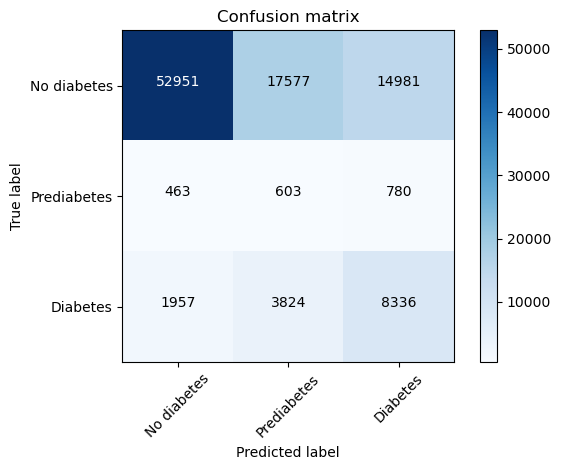

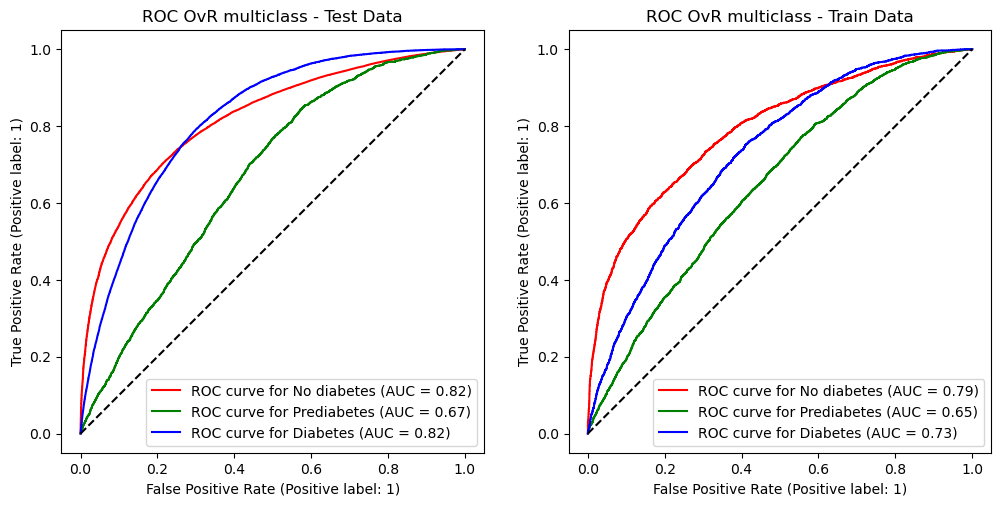

In [39]:
params = {
    'class_weight':'balanced',
    'max_iter':1000,
    'min_samples_leaf': 500,
    'loss':'log_loss'
}

param_grid = {
    'learning_rate':[0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10, 15, 20, 50, 100, 500, 1000],
    'max_leaf_nodes': range(3,100),
    'l2_regularization': [0.001, 0.01, 0.1]
}

cv_params = {
    'n_iter':30,
    'n_jobs':4
}


hbgb_under_cv = RandomizedSearchCV(
    HistGradientBoostingClassifier(**params, random_state=137), 
    param_grid, 
    **cv_params, 
    random_state=137)

rand_search_cv(hbgb_under_cv, 'hbgb_under_cv', X_under, 'X_under', y_under, 'y_under')

**Comments**

* Acceptably low overfitting amongst all classes.

In [40]:
pd.DataFrame(hbgb_under_cv.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_leaf_nodes,param_max_depth,param_learning_rate,param_l2_regularization,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,3.644724,0.093983,0.276358,0.012089,3,100,0.01,0.001,"{'max_leaf_nodes': 3, 'max_depth': 100, 'learn...",0.510473,0.506284,0.508079,0.508677,0.520646,0.510832,0.005086,1
23,7.341922,0.050911,0.457100,0.008853,54,10,0.01,0.01,"{'max_leaf_nodes': 54, 'max_depth': 10, 'learn...",0.502095,0.512867,0.505087,0.509276,0.514662,0.508797,0.004688,2
17,7.252122,0.114333,0.459218,0.016028,81,7,0.01,0.1,"{'max_leaf_nodes': 81, 'max_depth': 7, 'learni...",0.501496,0.511071,0.501496,0.509276,0.515859,0.507840,0.005609,3
4,7.154997,0.036140,0.456939,0.010371,28,7,0.01,0.1,"{'max_leaf_nodes': 28, 'max_depth': 7, 'learni...",0.501496,0.511071,0.501496,0.509276,0.515859,0.507840,0.005609,3
12,7.370048,0.067523,0.454330,0.014713,33,50,0.01,0.1,"{'max_leaf_nodes': 33, 'max_depth': 50, 'learn...",0.503890,0.509874,0.494315,0.511670,0.515260,0.507002,0.007333,5


In [41]:
pd.DataFrame(hbgb_under_cv.cv_results_).sort_values('rank_test_score').tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_leaf_nodes,param_max_depth,param_learning_rate,param_l2_regularization,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,7.268658,0.147331,0.463453,0.006084,17,100,0.1,0.001,"{'max_leaf_nodes': 17, 'max_depth': 100, 'lear...",0.486535,0.491323,0.476361,0.48833,0.500898,0.488689,0.007909,26
18,7.274286,0.156904,0.454844,0.011848,35,10,0.1,0.001,"{'max_leaf_nodes': 35, 'max_depth': 10, 'learn...",0.486535,0.491323,0.476361,0.48833,0.500898,0.488689,0.007909,26
11,7.201389,0.047646,0.457857,0.008130,33,500,0.1,0.001,"{'max_leaf_nodes': 33, 'max_depth': 500, 'lear...",0.486535,0.491323,0.476361,0.48833,0.500898,0.488689,0.007909,26
9,7.335116,0.067180,0.466211,0.013012,32,500,0.1,0.001,"{'max_leaf_nodes': 32, 'max_depth': 500, 'lear...",0.486535,0.491323,0.476361,0.48833,0.500898,0.488689,0.007909,26
15,7.243563,0.091446,0.464911,0.020581,44,10,0.1,0.1,"{'max_leaf_nodes': 44, 'max_depth': 10, 'learn...",0.479952,0.487732,0.478755,0.48833,0.499701,0.486894,0.007499,30


**Comments**

* Minor difference in test scores between best & worst performing parameters.

#### HGBC using OneVsRestClassifier  <a id='HGBC_OVRC'></a>

Start time:  16:29:38
End time:  16:32:55
Runtime:  0:03:17.816124 



,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"
1,rfc_under_2,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"
2,rfc_under_over,"{'n_estimators': 1000, 'criterion': 'entropy',...",None,None,"[0.81, 0.01, 0.44]","[0.72, 0.89, 0.73]","[0.94, 0.03, 0.3]","[0.71, 0.99, 0.67]","[0.71, 0.0, 0.79]","[0.72, 0.81, 0.79]"
3,rfc_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 30, 'max_features': 2, '...","[0.76, 0.05, 0.44]","[0.72, 0.65, 0.71]","[0.96, 0.03, 0.34]","[0.71, 0.75, 0.65]","[0.63, 0.29, 0.62]","[0.72, 0.58, 0.79]"
4,rfc_skb_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 135, 'max_features': 4, ...","[0.76, 0.05, 0.44]","[0.64, 0.41, 0.58]","[0.95, 0.03, 0.35]","[0.63, 0.49, 0.53]","[0.63, 0.29, 0.61]","[0.66, 0.36, 0.64]"
5,rfc_under_over_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'max_features': 4, 'max_depth': 50}","[0.81, 0.01, 0.44]","[0.73, 0.92, 0.74]","[0.95, 0.02, 0.3]","[0.75, 0.99, 0.69]","[0.71, 0.01, 0.79]","[0.72, 0.86, 0.81]"
6,rfc_under_ovrc_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'estimator__max_features': range(2, 21), 'est...","{'estimator__min_samples_split': 47, 'estimato...","[0.75, 0.05, 0.44]","[0.71, 0.62, 0.7]","[0.96, 0.03, 0.34]","[0.71, 0.7, 0.64]","[0.62, 0.31, 0.61]","[0.71, 0.56, 0.76]"
7,hbgb_under_cv,"{'class_weight': 'balanced', 'max_iter': 1000,...","{'learning_rate': [0.01, 0.05, 0.1], 'max_dept...","{'max_leaf_nodes': 3, 'max_depth': 100, 'learn...","[0.75, 0.05, 0.44]","[0.62, 0.4, 0.55]","[0.96, 0.03, 0.35]","[0.62, 0.44, 0.51]","[0.62, 0.33, 0.59]","[0.62, 0.37, 0.59]"
8,hbgb_under_ovrc_cv,"{'class_weight': {0: 1, 1: 2, 2: 2}, 'learning...","{'estimator__max_iter': [400, 500, 650, 900], ...","{'estimator__max_depth': 4, 'estimator__max_it...","[0.76, 0.05, 0.44]","[0.64, 0.44, 0.58]","[0.96, 0.03, 0.34]","[0.63, 0.5, 0.53]","[0.63, 0.31, 0.6]","[0.64, 0.39, 0.64]"


Confusion matrix, without normalization
[[53445 16527 15537]
 [  468   570   808]
 [ 2024  3616  8477]]


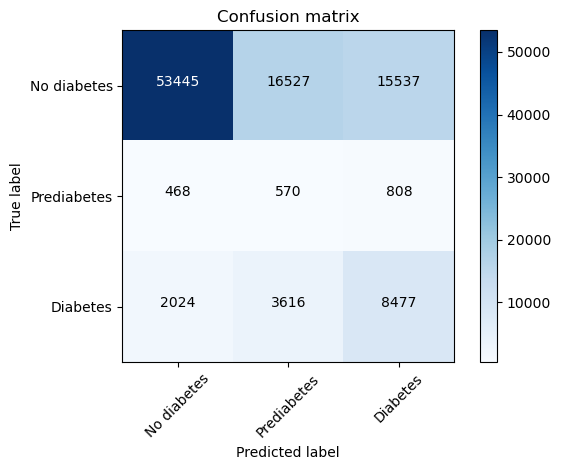

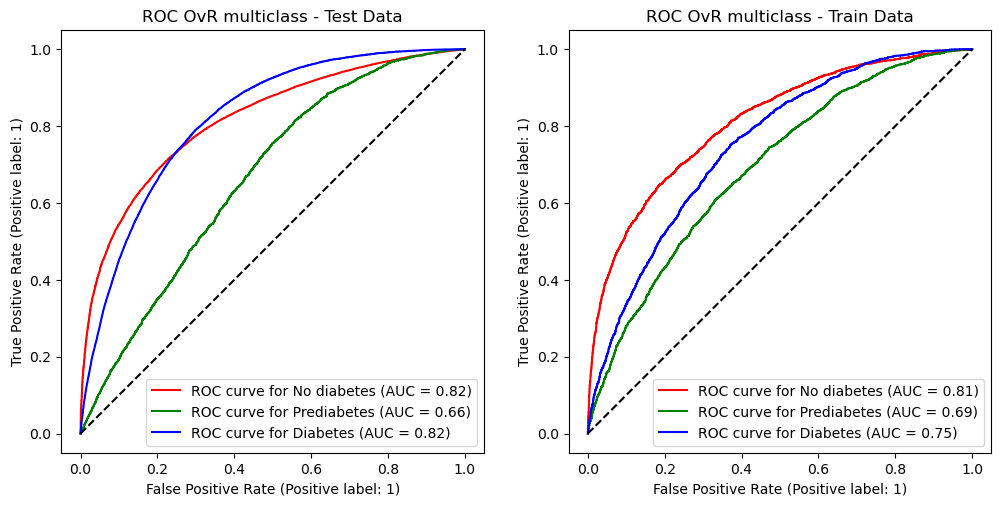

In [42]:
params = {
    'class_weight':{0:1, 1:2, 2:2},
    'learning_rate':0.01,
    'max_leaf_nodes': 100,
    'min_samples_leaf': 250
}

param_grid = {
    'estimator__max_iter':[400, 500, 650, 900],
    'estimator__max_depth':[3,4,5,6,7,8],
#    'estimator__max_leaf_nodes':[10, 100, 1000],  #Seems to make little to no difference
}

cv_params = {
    'n_jobs':4
}

ovrc = OneVsRestClassifier(HistGradientBoostingClassifier(**params), n_jobs=-4)

hbgb_under_ovrc_cv = GridSearchCV(
    ovrc,
    param_grid,
    **cv_params
)


rand_search_cv(hbgb_under_ovrc_cv, 'hbgb_under_ovrc_cv', X_under, 'X_under', y_under, 'y_under')

**Comments**

* Least overfitting out of all models so far for target class.

In [43]:
pd.DataFrame(hbgb_under_ovrc_cv.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,4.534171,0.046361,0.367640,0.006538,4,900,"{'estimator__max_depth': 4, 'estimator__max_it...",0.514063,0.515859,0.511670,0.502095,0.526032,0.513944,0.007686,1
8,2.803723,0.052599,0.194371,0.009059,5,400,"{'estimator__max_depth': 5, 'estimator__max_it...",0.511071,0.519449,0.521843,0.503890,0.511071,0.513465,0.006468,2
2,2.766756,0.066094,0.300387,0.023684,3,650,"{'estimator__max_depth': 3, 'estimator__max_it...",0.506284,0.518851,0.517654,0.503291,0.516457,0.512507,0.006419,3
23,8.669198,0.592373,0.504157,0.042293,8,900,"{'estimator__max_depth': 8, 'estimator__max_it...",0.520646,0.511670,0.502095,0.505685,0.521843,0.512388,0.007861,4
9,3.358112,0.070512,0.234444,0.011008,5,500,"{'estimator__max_depth': 5, 'estimator__max_it...",0.511670,0.516457,0.517654,0.503291,0.512867,0.512388,0.005055,4


In [44]:
pd.DataFrame(hbgb_under_ovrc_cv.cv_results_).sort_values('rank_test_score').tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,6.210367,0.094079,0.383994,0.008825,7,650,"{'estimator__max_depth': 7, 'estimator__max_it...",0.514063,0.508079,0.503291,0.504488,0.518851,0.509755,0.005893,20
0,1.856282,0.014594,0.152244,0.018029,3,400,"{'estimator__max_depth': 3, 'estimator__max_it...",0.508677,0.507481,0.516457,0.494315,0.521843,0.509755,0.009336,20
17,4.868324,0.044689,0.301182,0.017209,7,500,"{'estimator__max_depth': 7, 'estimator__max_it...",0.513465,0.513465,0.511670,0.501496,0.507481,0.509515,0.004567,22
20,4.237066,0.062235,0.241941,0.010179,8,400,"{'estimator__max_depth': 8, 'estimator__max_it...",0.514063,0.512867,0.508677,0.497307,0.511071,0.508797,0.006025,23
15,7.574443,0.118965,0.500240,0.022377,6,900,"{'estimator__max_depth': 6, 'estimator__max_it...",0.506284,0.506284,0.505087,0.502693,0.513465,0.506762,0.003599,24


Start time:  16:33:01
End time:  16:36:02
Runtime:  0:03:01.067554 



,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"
1,rfc_under_2,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"
2,rfc_under_over,"{'n_estimators': 1000, 'criterion': 'entropy',...",None,None,"[0.81, 0.01, 0.44]","[0.72, 0.89, 0.73]","[0.94, 0.03, 0.3]","[0.71, 0.99, 0.67]","[0.71, 0.0, 0.79]","[0.72, 0.81, 0.79]"
3,rfc_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 30, 'max_features': 2, '...","[0.76, 0.05, 0.44]","[0.72, 0.65, 0.71]","[0.96, 0.03, 0.34]","[0.71, 0.75, 0.65]","[0.63, 0.29, 0.62]","[0.72, 0.58, 0.79]"
4,rfc_skb_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 135, 'max_features': 4, ...","[0.76, 0.05, 0.44]","[0.64, 0.41, 0.58]","[0.95, 0.03, 0.35]","[0.63, 0.49, 0.53]","[0.63, 0.29, 0.61]","[0.66, 0.36, 0.64]"
5,rfc_under_over_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'max_features': 4, 'max_depth': 50}","[0.81, 0.01, 0.44]","[0.73, 0.92, 0.74]","[0.95, 0.02, 0.3]","[0.75, 0.99, 0.69]","[0.71, 0.01, 0.79]","[0.72, 0.86, 0.81]"
6,rfc_under_ovrc_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'estimator__max_features': range(2, 21), 'est...","{'estimator__min_samples_split': 47, 'estimato...","[0.75, 0.05, 0.44]","[0.71, 0.62, 0.7]","[0.96, 0.03, 0.34]","[0.71, 0.7, 0.64]","[0.62, 0.31, 0.61]","[0.71, 0.56, 0.76]"
7,hbgb_under_cv,"{'class_weight': 'balanced', 'max_iter': 1000,...","{'learning_rate': [0.01, 0.05, 0.1], 'max_dept...","{'max_leaf_nodes': 3, 'max_depth': 100, 'learn...","[0.75, 0.05, 0.44]","[0.62, 0.4, 0.55]","[0.96, 0.03, 0.35]","[0.62, 0.44, 0.51]","[0.62, 0.33, 0.59]","[0.62, 0.37, 0.59]"
8,hbgb_under_ovrc_cv,"{'class_weight': {0: 1, 1: 2, 2: 2}, 'learning...","{'estimator__max_iter': [400, 500, 650, 900], ...","{'estimator__max_depth': 4, 'estimator__max_it...","[0.76, 0.05, 0.44]","[0.64, 0.44, 0.58]","[0.96, 0.03, 0.34]","[0.63, 0.5, 0.53]","[0.63, 0.31, 0.6]","[0.64, 0.39, 0.64]"
9,hbgb_under_ovrc_cv_2,"{'learning_rate': 0.01, 'max_leaf_nodes': 100,...","{'estimator__max_iter': [400, 500, 650, 900], ...","{'estimator__max_depth': 6, 'estimator__max_it...","[0.75, 0.05, 0.44]","[0.64, 0.43, 0.58]","[0.95, 0.03, 0.34]","[0.63, 0.49, 0.53]","[0.62, 0.3, 0.6]","[0.64, 0.38, 0.64]"


Confusion matrix, without normalization
[[53323 16652 15534]
 [  477   557   812]
 [ 2042  3552  8523]]


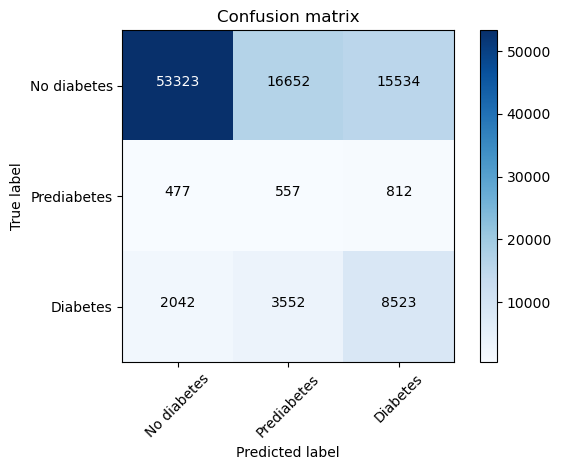

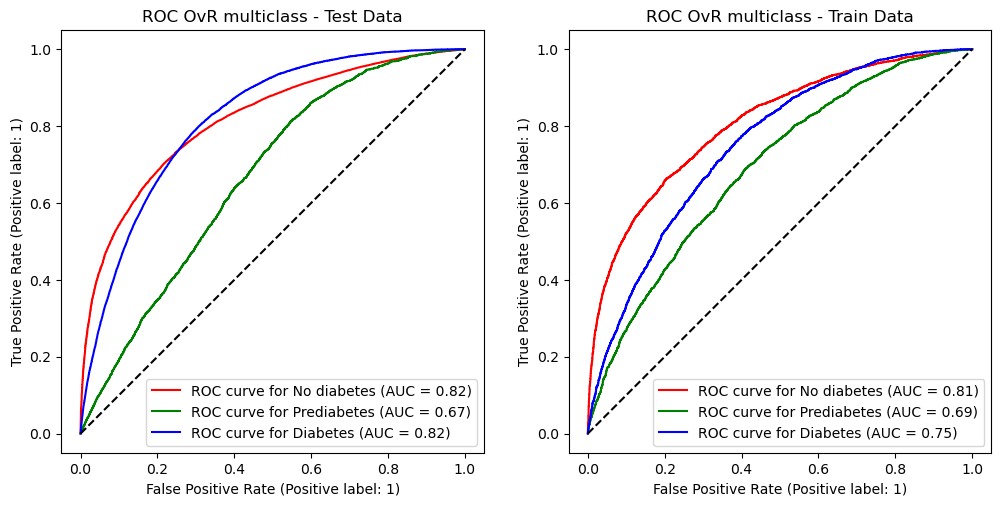

In [45]:
# GridSearchCV

params = {
    'learning_rate':0.01,
    'max_leaf_nodes': 100,
    'min_samples_leaf': 250
}

param_grid = {
    'estimator__max_iter':[400, 500, 650, 900],
    'estimator__max_depth':[3,4,5,6,7,8],
#    'estimator__max_leaf_nodes':[10, 100, 1000],  #Seems to make little to no difference
}

cv_params = {
    'n_jobs':4
}


ovrc = OneVsRestClassifier(HistGradientBoostingClassifier(**params, random_state=137), n_jobs=4)

hbgb_under_ovrc_cv_2 = GridSearchCV(
    ovrc,
    param_grid,
    **cv_params
)

# Using GridSearch instead
rand_search_cv(hbgb_under_ovrc_cv_2, 'hbgb_under_ovrc_cv_2', X_under, 'X_under', y_under, 'y_under')

* Consider grouping prediabetes & diabetes in confusion matrix analysis.  Predicting diabetes for prediabetes is perfectly acceptable.

* Likely many in 'No Diabetes' that have prediabetes.

In [46]:
pd.DataFrame(hbgb_under_ovrc_cv_2.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,3.605537,0.050626,0.226053,0.010812,6,400,"{'estimator__max_depth': 6, 'estimator__max_it...",0.512867,0.521245,0.521843,0.499701,0.515260,0.514183,0.008015,1
14,5.599897,0.086675,0.372508,0.012993,6,650,"{'estimator__max_depth': 6, 'estimator__max_it...",0.509874,0.518253,0.513465,0.506882,0.521245,0.513944,0.005264,2
8,3.102299,0.051934,0.217143,0.006310,5,400,"{'estimator__max_depth': 5, 'estimator__max_it...",0.512867,0.516457,0.515859,0.505685,0.514063,0.512986,0.003867,3
3,3.795841,0.058978,0.374596,0.006467,3,900,"{'estimator__max_depth': 3, 'estimator__max_it...",0.509874,0.509276,0.521843,0.508677,0.514063,0.512747,0.004926,4
10,4.814798,0.064806,0.336094,0.005774,5,650,"{'estimator__max_depth': 5, 'estimator__max_it...",0.508677,0.517056,0.518253,0.503890,0.514662,0.512507,0.005427,5


## Model Summaries <a id='Summaries'></a>

In [47]:
model_metrics

,Name,params,param_grid,best_params,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
0,rfc_under,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.75, 0.05, 0.44]","[0.66, 0.5, 0.62]","[0.95, 0.03, 0.35]","[0.66, 0.56, 0.57]","[0.62, 0.3, 0.59]","[0.66, 0.45, 0.67]"
1,rfc_under_2,"{'n_estimators': 500, 'criterion': 'entropy', ...",None,None,"[0.7, 0.04, 0.43]","[0.64, 0.52, 0.62]","[0.96, 0.02, 0.34]","[0.7, 0.54, 0.57]","[0.55, 0.35, 0.6]","[0.59, 0.51, 0.69]"
2,rfc_under_over,"{'n_estimators': 1000, 'criterion': 'entropy',...",None,None,"[0.81, 0.01, 0.44]","[0.72, 0.89, 0.73]","[0.94, 0.03, 0.3]","[0.71, 0.99, 0.67]","[0.71, 0.0, 0.79]","[0.72, 0.81, 0.79]"
3,rfc_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 30, 'max_features': 2, '...","[0.76, 0.05, 0.44]","[0.72, 0.65, 0.71]","[0.96, 0.03, 0.34]","[0.71, 0.75, 0.65]","[0.63, 0.29, 0.62]","[0.72, 0.58, 0.79]"
4,rfc_skb_under_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'min_samples_split': 135, 'max_features': 4, ...","[0.76, 0.05, 0.44]","[0.64, 0.41, 0.58]","[0.95, 0.03, 0.35]","[0.63, 0.49, 0.53]","[0.63, 0.29, 0.61]","[0.66, 0.36, 0.64]"
5,rfc_under_over_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'max_features': range(2, 21), 'max_depth': [5...","{'max_features': 4, 'max_depth': 50}","[0.81, 0.01, 0.44]","[0.73, 0.92, 0.74]","[0.95, 0.02, 0.3]","[0.75, 0.99, 0.69]","[0.71, 0.01, 0.79]","[0.72, 0.86, 0.81]"
6,rfc_under_ovrc_cv,"{'class_weight': 'balanced', 'n_estimators': 1...","{'estimator__max_features': range(2, 21), 'est...","{'estimator__min_samples_split': 47, 'estimato...","[0.75, 0.05, 0.44]","[0.71, 0.62, 0.7]","[0.96, 0.03, 0.34]","[0.71, 0.7, 0.64]","[0.62, 0.31, 0.61]","[0.71, 0.56, 0.76]"
7,hbgb_under_cv,"{'class_weight': 'balanced', 'max_iter': 1000,...","{'learning_rate': [0.01, 0.05, 0.1], 'max_dept...","{'max_leaf_nodes': 3, 'max_depth': 100, 'learn...","[0.75, 0.05, 0.44]","[0.62, 0.4, 0.55]","[0.96, 0.03, 0.35]","[0.62, 0.44, 0.51]","[0.62, 0.33, 0.59]","[0.62, 0.37, 0.59]"
8,hbgb_under_ovrc_cv,"{'class_weight': {0: 1, 1: 2, 2: 2}, 'learning...","{'estimator__max_iter': [400, 500, 650, 900], ...","{'estimator__max_depth': 4, 'estimator__max_it...","[0.76, 0.05, 0.44]","[0.64, 0.44, 0.58]","[0.96, 0.03, 0.34]","[0.63, 0.5, 0.53]","[0.63, 0.31, 0.6]","[0.64, 0.39, 0.64]"
9,hbgb_under_ovrc_cv_2,"{'learning_rate': 0.01, 'max_leaf_nodes': 100,...","{'estimator__max_iter': [400, 500, 650, 900], ...","{'estimator__max_depth': 6, 'estimator__max_it...","[0.75, 0.05, 0.44]","[0.64, 0.43, 0.58]","[0.95, 0.03, 0.34]","[0.63, 0.49, 0.53]","[0.62, 0.3, 0.6]","[0.64, 0.38, 0.64]"


**Comments**

Choice of best model is ambiguous. There is no clear winner with respect to recall scores of the target class.  Adjusting parameters to increase recall scores comes at an unacceptable cost to other metrics.  It may not be possible to create a sufficiently high performing model for the target class and variable using this data.